In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt

In [2]:
tsla_filepath = os.path.join(os.getcwd(), 'tsla.csv')
goog_filepath = os.path.join(os.getcwd(), 'goog.csv')
eth_filepath = os.path.join(os.getcwd(), 'eth.csv')
btc_filepath = os.path.join(os.getcwd(), 'btc.csv')

tsla_df = pd.read_csv(tsla_filepath)
goog_df = pd.read_csv(goog_filepath)
eth_df = pd.read_csv(eth_filepath)
btc_df = pd.read_csv(btc_filepath)

In [3]:
tsla_df = tsla_df[pd.to_numeric(tsla_df['Close'], errors='coerce').notna()]
tsla_df = tsla_df[['Close']]
tsla_df['Close'] = tsla_df['Close'].astype(float)  # Ensure numeric type
tsla_df = tsla_df.reset_index(drop=True)

In [4]:
# Function to preprocess data (splitting, scaling, and preparing training data)
def preprocess_data(data, train_split=0.7, window_size=100):
    # Splitting the data into training and testing
    data_training = data[0:int(len(data) * train_split)]
    data_testing = data[int(len(data) * train_split):]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_training_array = scaler.fit_transform(data_training)

    # Preparing training data
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i - window_size:i])
        y_train.append(data_training_array[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    return x_train, y_train, data_testing, scaler

In [5]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [6]:
# Function to prepare test data
def prepare_test_data(data_testing, data_training, scaler, window_size=100):
    past_data = data_training.tail(window_size)
    final_data = pd.concat([past_data, data_testing], ignore_index=True)
    input_data = scaler.transform(final_data)

    x_test, y_test = [], []
    for i in range(window_size, len(input_data)):
        x_test.append(input_data[i - window_size:i])
        y_test.append(input_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    return x_test, y_test

In [7]:
# Function to scale back and plot predictions
def plot_predictions(y_test, y_predicted, scaler):
    # Reverse scaling
    scale_factor = 1 / scaler.scale_[0]
    y_test = y_test * scale_factor
    y_predicted = y_predicted * scale_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Original Price', linewidth=1)
    plt.plot(y_predicted, label='Predicted Price', linewidth=1)
    plt.legend()
    plt.show()

In [8]:
# Main function to train and test the model for a given stock
def train_and_test_lstm(stock_data, epochs=10, window_size=100):
    # Preprocessing the data
    x_train, y_train, data_testing, scaler = preprocess_data(stock_data[['Close']], window_size=window_size)

    # Building the model
    model = build_lstm_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, epochs=epochs, batch_size=32)

    # Preparing test data
    x_test, y_test = prepare_test_data(data_testing, stock_data[['Close']], scaler, window_size=window_size)

    # Making predictions
    y_predicted = model.predict(x_test)

    # Plotting predictions
    plot_predictions(y_test, y_predicted, scaler)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - loss: 0.0095
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.0014
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.0014
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.0016
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - loss: 0.0011
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - loss: 0.0014
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - loss: 0.0011
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - loss: 0.0013
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - loss: 0.0011
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - loss: 0.0010
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


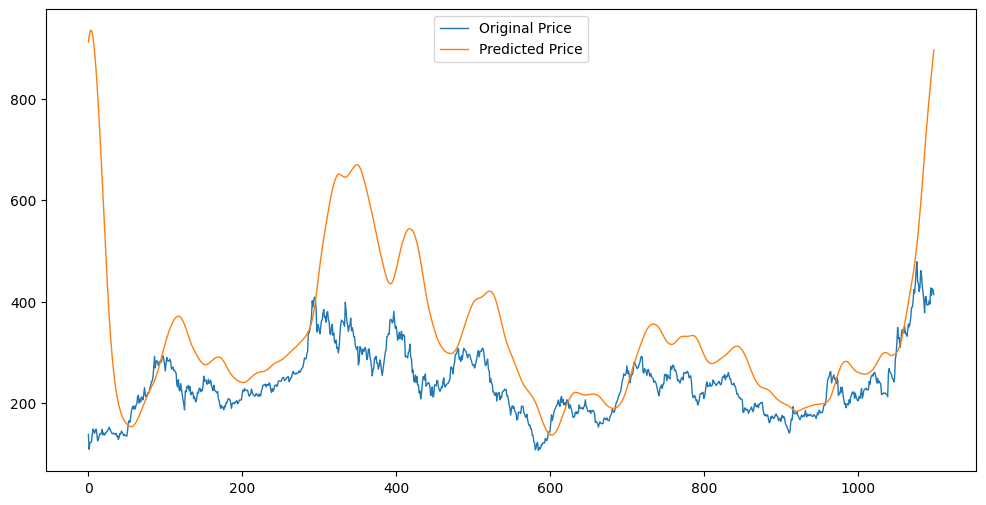

In [9]:
train_and_test_lstm(tsla_df)

In [10]:
train_and_test_lstm(goog_df)

ValueError: could not convert string to float: 'GOOG'

In [ ]:
train_and_test_lstm(goog_df)

In [ ]:
train_and_test_lstm(goog_df)